In [1]:
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pandas as pd
import string
import numpy as np
import six
import dataframe_image as dfi

import matplotlib.pyplot as plt

In [2]:
import pprint
import csv
import ast
import re

from collections import Counter
from operator import itemgetter

import sqlite3 as sql
import time

from importlib import reload
from shutil import copyfile

In [3]:
#definition de la bdd
db = 'data/memoire.db'

In [4]:
#connexion à la bdd, crée la bdd si elle n'existe pas encore
cn=sql.connect(db)

In [5]:
#suppression de table dans la BDD
#cursor = cn.cursor()
#delete_table = """DROP TABLE nom_de_la_table"""
#cursor.execute(delete_table)

## Recherche dans la BDD

### Lister les colonnes de la BDD

In [46]:

conn = sql.connect(db)

c.execute('SELECT * FROM Silex')
#c.execute('SELECT * FROM query WHERE pk_query = 10')

rc = c.fetchall()
names = list(map(lambda x: x[0], c.description))


# fermer la connexion
conn.close()

# imprimer et inspecter le résultat
names

['idx',
 'N°_dépot',
 'N°_caisse',
 'Localité',
 'année',
 'N°_cantonal',
 'Lieu_dit',
 'N°_terrain',
 'Matière',
 'Caractéristique',
 'Description_de_l_objet',
 'Altitude',
 'UF',
 'Période_culturelle',
 'Année_de_restauration',
 'Etat_de_conservation',
 'Fiche_ITMS_non',
 'Remarque_restauration',
 'Coord_X',
 'Coord_Y',
 'Mat_prem',
 'Typologie',
 'Integrite',
 'Etat_surface',
 'Longueur',
 'Largeur',
 'Epaisseur',
 'Poids',
 'Type_de_talon',
 'Bulbe',
 'Levre',
 'Esquille_bulbaire',
 'Retouche',
 'Cortex',
 'Dessin',
 'Remarque',
 'Technologie']

### Extraction des données

In [5]:
### Définir la ligne de la base de données à utiliser (inspécter préalablement la base de données)
#N_cant = 7923

# connnexion à la base de données
conn = sql.connect(db)
#Colonne="Descroption_de_l'objet"

### exécuter la requëte sur la base de donées SQLite pour récupérer les valeurs que contient la ligne
c = conn.cursor()
#c.execute('SELECT * FROM base')

c.execute('SELECT N°_cantonal, Technologie FROM Silex')
#c.execute('SELECT * FROM query WHERE pk_query = 10')

rc = c.fetchall()

# fermer la connexion
conn.close()

# imprimer et inspecter le résultat
rc[1]
len(rc)

878

In [6]:
df_silex = pd.DataFrame(rc, columns=['N°_Cantonal','Technologie'])
df_silex.head()

,N°_Cantonal,Technologie
0,7827,Nucléus
1,7834,Lamelle
2,7835,Nucléus
3,7840,Lamelle
4,7844,Lame


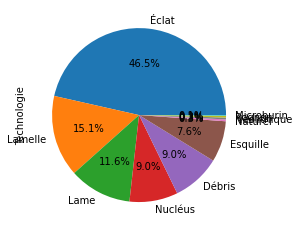

In [90]:
df_plot=df_silex["Technologie"].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')

In [13]:
fig=df_plot.get_figure()
fig.savefig('Typologie')

In [91]:
df_pourcent=df_silex.groupby('Technologie').size()

In [92]:
100*df_pourcent/878

Technologie
Débris          8.997722
Esquille        7.630979
Lame           11.617312
Lamelle        15.148064
Microburin      0.113895
Naturel         0.341686
Nucléus         8.997722
Néolithique     0.341686
Rognon          0.341686
Éclat          46.469248
dtype: float64

In [111]:
df_silex['Compte']=df_silex['Technologie']

In [24]:
df_group=df_silex.groupby('Technologie', as_index=True).size()

In [25]:
df_group

Technologie
Débris          79
Esquille        67
Lame           102
Lamelle        133
Microburin       1
Naturel          3
Nucléus         79
Néolithique      3
Rognon           3
Éclat          408
dtype: int64

In [26]:
df_group=df_silex.groupby('Technologie', as_index=False).size()
df_group['nombre']=df_group['size']
df_group['%']=df_group['size']
df_group['%']=100*df_group['%']/df_group['size'].sum()
del df_group['size']

In [18]:
df_group.rename(columns = {'Technologie':'Objet'}, inplace = True)

In [19]:
df_group.round(2)

,Objet,nombre,%
0,Débris,79,9.00
1,Esquille,67,7.63
2,Lame,102,11.62
3,Lamelle,133,15.15
4,Microburin,1,0.11
5,Naturel,3,0.34
6,Nucléus,79,9.00
7,Néolithique,3,0.34
8,Rognon,3,0.34
9,Éclat,408,46.47


In [29]:
df_total=df_group.append(df_group.sum(numeric_only=True).rename('Total'))

In [39]:
df_total.Technologie.fillna(value='Total', inplace=True)
df_total

,Technologie,nombre,%
0,Débris,79.0,8.997722
1,Esquille,67.0,7.630979
2,Lame,102.0,11.617312
3,Lamelle,133.0,15.148064
4,Microburin,1.0,0.113895
5,Naturel,3.0,0.341686
6,Nucléus,79.0,8.997722
7,Néolithique,3.0,0.341686
8,Rognon,3.0,0.341686
9,Éclat,408.0,46.469248


In [47]:
df_total.nombre=df_total.nombre.astype(int)

In [10]:
dfi.export(df_group, 'df_styled.png')

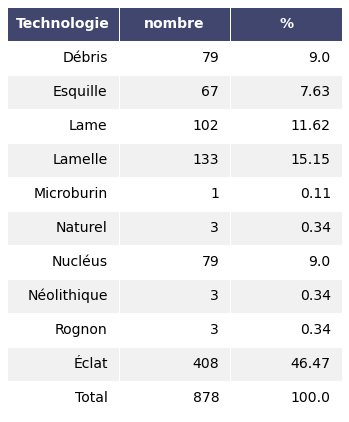

In [48]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax
tableau=render_mpl_table(df_total.round({'%':2}), header_columns=0, col_width=2.0)

In [49]:
tableau.get_figure().savefig('Liste_objets.png')

In [165]:
export_png(tableau, filename = tableau.png)

NameError: name 'export_png' is not defined

In [79]:
df_pourcent

Technologie
Débris          79
Eclat            2
Esquille        67
Lame           102
Lamelle        133
Microburin       1
Naturel          3
Nucléus         79
Néolithique      3
Rognon           3
Éclat          406
dtype: int64

In [60]:
df_silex

,N°_Cantonal,Technologie
0,7827,Nucléus
1,7834,Lamelle
2,7835,Nucléus
3,7840,Lamelle
4,7844,Lame
...,...,...
873,1911,Éclat
874,1912,Débris
875,1914,Éclat
876,2236,Éclat


In [31]:
df_silex['Typo']=df_silex['Typologie']
df_silex[:10]

,N°_Cantonal,UF,Typologie,Typo
0,7827,A5,Nucleus,Nucleus
1,7834,A5,Lamelle,Lamelle
2,7835,A5,Nucleus,Nucleus
3,7840,A6,Lamelle,Lamelle
4,7844,A7,Lame,Lame
5,7846,A7,Lamelle,Lamelle
6,7850,A7,Nucleus,Nucleus
7,7851,A7,Lamelle,Lamelle
8,7854,A7,Esquille,Esquille
9,7855,A8,Nucleus,Nucleus


In [42]:
df_silex['Ty']=df_silex['Typologie']

In [51]:
### Regrouper par UF
place_count = df_silex.groupby(['UF', 'Typologie', 'Ty'], as_index=False) \
      .agg({'Typologie': ','.join, 'Typo': 'count'}).sort_values(by=['UF'])
print(len(place_count))
place_count[:10]

321


,UF,Ty,Typologie,Typo
0,A-B5,Esquille,Esquille,1
1,A-B5,Lamelle,Lamelle,1
2,A-B5,éclat,"éclat,éclat,éclat,éclat,éclat,éclat,éclat",7
3,A10,Esquille,"Esquille,Esquille",2
4,A10,Lame,Lame,1
5,A10,éclat,"éclat,éclat,éclat,éclat",4
10,A11,éclat,"éclat,éclat,éclat,éclat,éclat,éclat,éclat,écla...",20
8,A11,Lamelle,"Lamelle,Lamelle,Lamelle,Lamelle",4
9,A11,Nucleus,Nucleus,1
6,A11,Esquille,Esquille,1


In [53]:
df_carre=place_count.pivot(index='UF', columns='Ty', values='Typo')
df_carre[:10]

Ty,Armature,Esquille,Lame,Lamelle,Nucleus,Rognon,grattoir,éclat
UF,,,,,,,,
A-B5,NaN,1.0,NaN,1.0,NaN,NaN,NaN,7.0
A10,NaN,2.0,1.0,NaN,NaN,NaN,NaN,4.0
A11,NaN,1.0,2.0,4.0,1.0,NaN,NaN,20.0
A3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
A5,NaN,NaN,NaN,1.0,2.0,NaN,NaN,4.0
A6,NaN,NaN,NaN,1.0,NaN,NaN,NaN,7.0
A7,NaN,1.0,1.0,2.0,1.0,NaN,NaN,6.0
A8,NaN,1.0,1.0,3.0,1.0,NaN,NaN,1.0


In [54]:
df_carre.to_excel(r'Typo_par_carre.xlsx', index = True)

In [224]:
g=list()
for i in range(len(rc)):
    if "poi" in rc[i][0]:
        g.append(rc[i])
    
len(g)

18

In [225]:
g

[('pointe retouchée à tronquature', 7910),
 ('pointe retouchée', 7934),
 ('pointe à tronquature', 7959),
 ('pointe à retouches denticulées sur 1 côté', 8105),
 ('pointe à tronquature cassée', 8171),
 ('pointe retouchée ?', 8179),
 ('pointe de flèche à ailette, bord denticulé', 8196),
 ('pointe corticale à tronquature', 8211),
 ('pointe  ', 8227),
 ('pointe à tronquature oblique', 8279),
 ('pointe à tronquature ou trapèze?', 8317),
 ('pointe à tronquature oblique', 8355),
 ('pointe à tronquature oblique', 8369),
 ('pointe corticale ?', 8428),
 ('pointe ', 8500),
 ('1 pointe de flèche néol.', 8511),
 ('pointe ', 10465),
 ('pointe', 1869)]

In [226]:
b=list()
for i in range(len(g)):
    a=list(g[i])
    a[0]='Armature'
    b.append(a)
b[4:8]

[['Armature', 8171],
 ['Armature', 8179],
 ['Armature', 8196],
 ['Armature', 8211]]

In [5]:
cn = sql.connect(db)
c = cn.cursor()

# Insérer les données
c.execute("ALTER TABLE Silex ADD COLUMN Accident TEXT REFERENCES Accident(Abbrev)")

# valider l'insertion et fermer la base de données
cn.commit()
cn.close()